In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

Extracting ./MNIST_data\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw


Extracting ./MNIST_data\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw


Extracting ./MNIST_data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST_data\MNIST\raw




Extracting ./MNIST_data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST_data\MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [4]:
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='Adam', **optim_params):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        self.dropout = dropout

        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        
        self._loss = F.nll_loss(output, target, **kwargs)  # используют совместно с log_softmax, см. https://habr.com/ru/post/433804/ и 
        # https://pytorch.org/docs/master/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(
            target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [6]:
models = {'SGD': Net(False, False, 'SGD', lr=1e-3),
          'momentum': Net(False, False, 'SGD', lr=1e-3, momentum=0.9),
          'Adadelta': Net(False, False, 'Adadelta', lr=1.),
          'RMSProp': Net(False, False, 'RMSProp', lr=1e-2),
          'Adam': Net(False, False, 'Adam', lr=1e-3), 
         }
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [8]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [9]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.323938 momentum: 2.300539 Adadelta: 2.344110 RMSProp: 2.326360 Adam: 2.318903
Train Epoch: 1 [10000/50000 (20%)]	Losses SGD: 2.212920 momentum: 1.440644 Adadelta: 0.287186 RMSProp: 2.532246 Adam: 0.332868
Train Epoch: 1 [20000/50000 (40%)]	Losses SGD: 2.138831 momentum: 0.829834 Adadelta: 0.254205 RMSProp: 2.880334 Adam: 0.269367
Train Epoch: 1 [30000/50000 (60%)]	Losses SGD: 2.094542 momentum: 0.694439 Adadelta: 0.276769 RMSProp: 2.476705 Adam: 0.124588
Train Epoch: 1 [40000/50000 (80%)]	Losses SGD: 2.011333 momentum: 0.470174 Adadelta: 0.118188 RMSProp: 2.770193 Adam: 0.121036
Train Epoch: 1 [50000/50000 (100%)]	Losses SGD: 1.850544 momentum: 0.576329 Adadelta: 0.193814 RMSProp: 2.967372 Adam: 0.066400
Test set:
SGD: Loss: 1.8649	Accuracy: 5915.0/10000 (59%)
momentum: Loss: 0.4168	Accuracy: 8905.0/10000 (89%)
Adadelta: Loss: 0.1478	Accuracy: 9537.0/10000 (95%)
RMSProp: Loss: 2.4495	Accuracy: 1006.0/10000 (10%)
Adam: Loss: 0.1485	Accuracy: 9

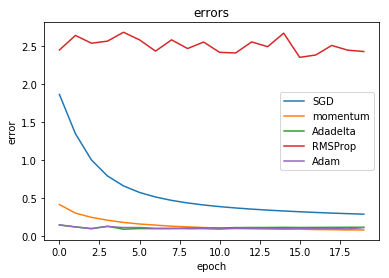

In [10]:
plot_graphs(test_log, 'loss')

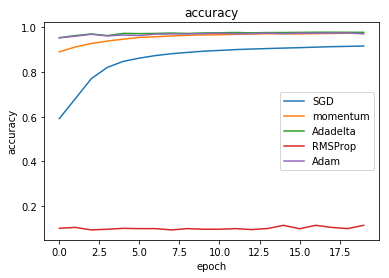

In [11]:
plot_graphs(test_log, 'accuracy')